In [29]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import sys, os
import numpy as np
import lumapi
import utils


In [30]:
emeApi = lumapi.MODE()

In [31]:
emeApi.importmaterialdb('silicon_thermal.mdf')

## Parâmetros Geometria

In [32]:
um = 1e-6
nm = 1e-9

thickness = 0.22*um
thick_BOX = 2*um

W_bragg = 1530*nm
#1130nm
width = 0.5*um # Waveguide width
Delta_W = 20*nm # Corrugation width
W_great = width+ Delta_W
W_small = width - Delta_W

L_pd = 324*nm # Grating period

material_Si = 'silicon_thermal'
#'Si3N4 (Silicon Nitride) - Kischkat'
#'Si3N4 (Silicon Nitride) - Luke' 
#'Si3N4 (Silicon Nitride) - Phillip'
#'silicon_thermal' 
#"Si (Silicon) - Palik"
material_BOX = "SiO2 (Glass) - Palik"

w_box = 2*width
t_box = 2*um
nb = 10000
wvg = np.linspace(1500e-9, 1600e-9, nb)


## Geometry

In [33]:
group_index_high ,neff_high,group_index_low,neff_low = utils.construir_bragg_e_retornar_indices_efetivos(emeApi,L_pd,W_great,W_small,thickness,material_Si,material_BOX,3*width,3*thickness,3*W_great,3*thickness,Temperatura=298)
print("high index - ng = ", group_index_high," neff = ", neff_high)

print("low index - ng = ", group_index_low," neff = ", neff_low)

high index - ng =  4.4553724803625165  neff =  2.390599278394741
low index - ng =  4.357813467947369  neff =  2.456719556901163


## Bragg periodicity ($\Lambda$)

$$
\Lambda = \frac{\lambda_{Bragg}}{2n_{eff}}
$$

Where,

$$
n_{eff} = \frac{{n_{eff}}_1+{n_{eff}}_2}{2}
$$

In [34]:
Lambda = W_bragg/((neff_low+neff_high))
print("Lambda = ", Lambda*1e9, " nm")

S = np.linspace(0,0.008,10)

print(S*1e3," milistrain")
Lambda_strain = Lambda*(1+S)
print(Lambda_strain*1e9, "nm")

Lambda =  315.6384079502378  nm
[0.         0.88888889 1.77777778 2.66666667 3.55555556 4.44444444
 5.33333333 6.22222222 7.11111111 8.        ]  milistrain
[315.63840795 315.91897542 316.1995429  316.48011037 316.76067785
 317.04124532 317.32181279 317.60238027 317.88294774 318.16351521] nm


## Temperature Results

In [35]:
Temperatura = np.linspace(25,75,0)+273


if(len(Temperatura)>0):
    Transmissao_T = []
    S11_modulo = []
    S11_fase = []
    S21_modulo = []
    S21_fase = []

    for i in range(len(Temperatura)):
        R, S11M, S11F,S21M,S21F = utils.bragg_integrado_simples(emeApi,Lambda,W_great,W_small,thickness,w_box,t_box,material_Si,material_BOX,wvg[0],wvg[-1],nb,Temperatura=Temperatura[i])
        
        Transmissao_T.append(R)
        S11_modulo.append(S11M)
        S11_fase.append(S11F)
        S21_modulo.append(S21M)
        S21_fase.append(S21F)
    


## S Parameters Export - Temperature

In [36]:
if(len(Temperatura)):
    S11 = np.zeros((len(wvg), 2*len(Temperatura)))
    S21 = np.zeros((len(wvg), 2*len(Temperatura)))

    for i in range(0,len(Temperatura),1):
        S11[:,2*i] = S11_modulo[i]
        S11[:,2*i+1] = S11_fase[i]

        S21[:,2*i] = S21_modulo[i]
        S21[:,2*i+1] = S21_fase[i]


In [37]:
if(len(Temperatura)>0):
    filepath = r"C:\Users\gson5\Downloads\Photonics-API-lumapi\SILICON BRAGG\BRAGG TEMPERATURE"
    tamanho = len(os.listdir(filepath))

    for i in range(tamanho):
        os.remove(fr"C:\Users\gson5\Downloads\Photonics-API-lumapi\SILICON BRAGG\BRAGG TEMPERATURE\bragg_temperature_{i+1}.dat")

In [38]:
if(len(Temperatura)>0):
    # Parâmetros
    c = 3e8
    coln = 3
    TM = np.transpose(Temperatura)
    numMode = 1  # 1 modo
    numPort = 2  # 2 portas
    modeLabel = ["TE"]  # lista com rótulos de modos

    for i in range(len(Temperatura)):
        filename = os.getcwd() + fr"\BRAGG TEMPERATURE\bragg_temperature_{i+1}.dat"
        with open(filename, "w") as f:
            for kk in range(numMode):
                for mm in range(numPort):  # porta de saída
                    for nn in range(numPort):  # porta de entrada
                                mystr = (
                                    f"(\"port {mm+1}\",\"{modeLabel[kk]}\",{kk+1},"
                                    f"\"port {nn+1}\",1,\"modulation\")\n"
                                    f"(1,{1})\n"
                                )
                                f.write(mystr)

                                f.write(f"{Temperatura[i]:.5f}" + "\n")

                                f.write(f"({len(wvg)},{coln})\n")

                                # Seleciona o conjunto de dados correto
                                if mm == 0 and nn == 0 and kk == 0:  # S11
                                    mymtrx = np.column_stack((c / wvg, S11[:,2*i:2*i+2]))
                                elif mm == 1 and nn == 0 and kk == 0:  # S21
                                    mymtrx = np.column_stack((c / wvg, S21[:,2*i:2*i+2]))
                                else:
                                    mymtrx = np.column_stack((c / wvg, S11[:,2*i:2*i+2]))

                                # Escreve os dados numéricos
                                np.savetxt(f, mymtrx, fmt="%.6e", delimiter="\t")


In [39]:
if(len(Temperatura)>0):
    plt.figure(figsize=(10, 10))

    for i in range(len(Temperatura)):
        plt.plot(
            wvg * 1e9,
            Transmissao_T[i],
            label=f"{Temperatura[i] - 273:.1f} °C",
            linewidth=2
        )

    x_max1, _ = utils.achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
        Transmissao_T[0], wvg*1e9, 1500, 1600
    )
    x_max2, _ = utils.achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
        Transmissao_T[-1], wvg*1e9, 1500, 1600
    )

    # plt.axvline(x=x_max1, color ="blue", linestyle ='--')
    # plt.axvline(x=x_max2, color ="red", linestyle ='--')

    plt.xlim(x_max1 - 10, x_max2 + 10)

    plt.xlabel("Wavelength [nm]", fontsize=14)
    plt.ylabel("Reflectance", fontsize=14)
    plt.title("Reflectance vs Wavelength", fontsize=16, pad=15)

    plt.legend(title="Temperatura", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\reflectance_vs_wavelength_temperatura", dpi=300, bbox_inches="tight")

    plt.show()


In [40]:
if (len(Temperatura)>0):
    frequencia_onde_ocorre_maxima_transmissao,_ = utils.analise_comprimento_de_onda_para_sensor(Temperatura,Transmissao_T,wvg*1e9,1500,1600)


In [41]:
if(len(Temperatura)>0):
    plt.figure(figsize=(10, 10))

    plt.plot(
        Temperatura - 273,
        frequencia_onde_ocorre_maxima_transmissao,
        '-o',
        color='blue',
        markerfacecolor='none',  # bola vazada
        markersize=8,
        linewidth=2,
        label="Resonance"
    )

    plt.xlabel("Temperature [°C]", fontsize=14)
    plt.ylabel("Wavelength Resonance [nm]", fontsize=14)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\ressonancia_vs_temperatura.png", dpi=300, bbox_inches="tight")

    plt.show()


## Strain Results

$$
l = l_0(1+S)
$$


In [42]:
variacao_apenas_em_x = 1
variacao_apenas_em_y = 0
variacao_apenas_em_z = 0

Reflectance = []
S11_modulo = []
S11_fase = []
S21_modulo = []
S21_fase = []
for i in range(len(S)):
    R, S11M, S11F,S21M,S21F = utils.bragg_integrado_simples(emeApi,Lambda*(1+S[i]*variacao_apenas_em_x),
                                                            W_great*(1+S[i]*variacao_apenas_em_y),W_small*(1+S[i]*variacao_apenas_em_y),
                                                            thickness*(1+S[i]*variacao_apenas_em_z),w_box*(1+S[i]*variacao_apenas_em_y),
                                                            t_box*(1+S[i]*variacao_apenas_em_z),material_Si,material_BOX,wvg[0],wvg[-1],nb,
                                                            periods=150)


    Reflectance.append(R)
    S11_modulo.append(S11M)
    S11_fase.append(S11F)
    S21_modulo.append(S21M)
    S21_fase.append(S21F)

In [46]:
neff = []

# for i in range(len(S)):
#     group_index_high ,neff_high,group_index_low,neff_low = utils.construir_bragg_e_retornar_indices_efetivos(emeApi,Lambda*(1+S[i]*variacao_apenas_em_x)
#                                                                                                              ,W_great*(1+S[i]*variacao_apenas_em_y),W_small*(1+S[i]*variacao_apenas_em_y),thickness*(1+S[i]*variacao_apenas_em_z),material_Si,material_BOX,
#                                                                                                              3*width*(1+S[i]*variacao_apenas_em_y),3*thickness*(1+S[i]*variacao_apenas_em_z),3*W_great*(1+S[i]*variacao_apenas_em_y),
#                                                                                                              3*thickness*(1+S[i]*variacao_apenas_em_z),Temperatura=298)
#     neff.append((neff_low+neff_high)/2)



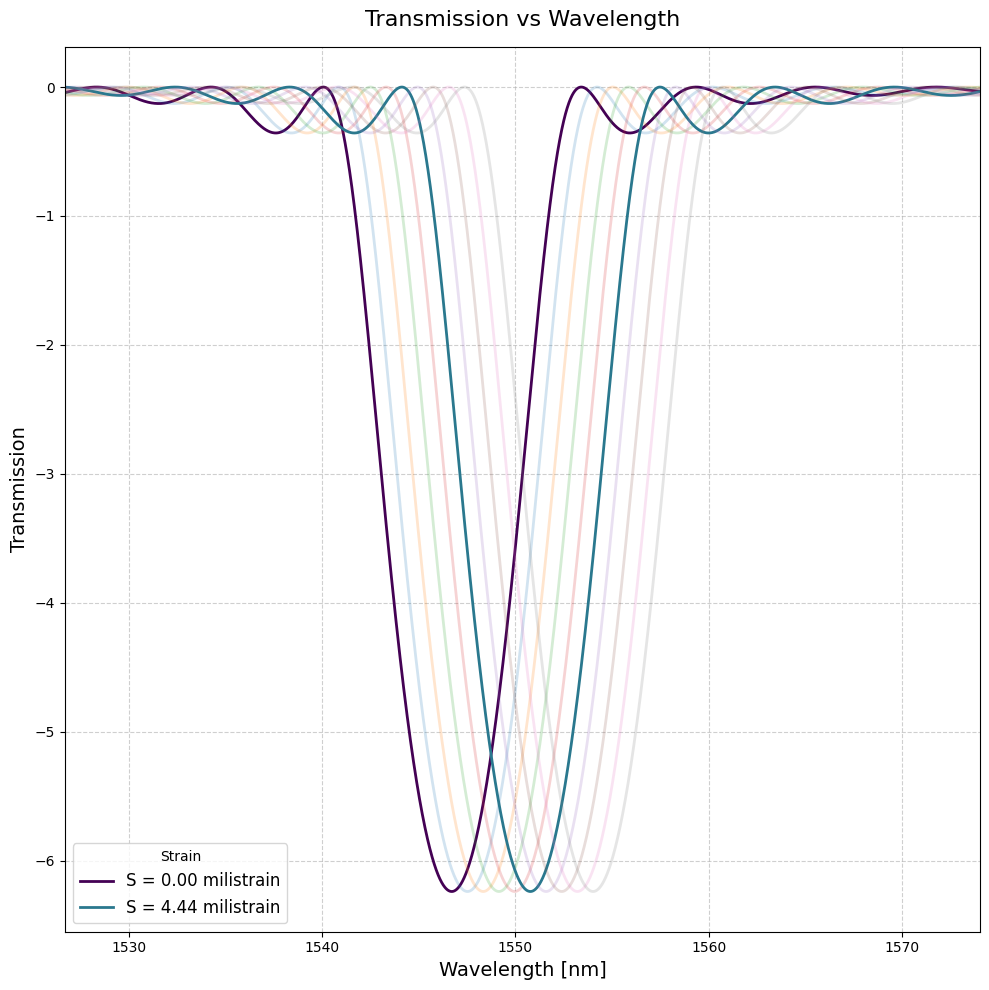

In [44]:
cmap = plt.cm.viridis 

plt.figure(figsize=(10, 10))

for i in range(len(S)):
    if (i%5 == 0):
        plt.plot(
            wvg * 1e9,
            20*np.log10(S21_modulo[i]),
            markerfacecolor='none',  # bola vazada
            markersize=6,
            linewidth=2,
            color=cmap(0.8*i/len(S)),
            label = f"S = {S[i]*1e3:.2f} milistrain"
        )
    else:
        plt.plot(
            wvg * 1e9,
            20*np.log10(S21_modulo[i]),
            markerfacecolor='none',  # bola vazada
            markersize=6,
            alpha = 0.2,
            linewidth=2,
        )

x_max_S1, _ = utils.achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
    Reflectance[0]**2, wvg*1e9, wvg[0]*1e9, wvg[-1]*1e9
)
x_max_S2, _ = utils.achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
    Reflectance[-1]**2, wvg*1e9, wvg[0]*1e9, wvg[-1]*1e9
)

plt.xlim(x_max_S1 - 20, x_max_S2 + 20)

plt.xlabel("Wavelength [nm]", fontsize=14)
plt.ylabel("Transmission", fontsize=14)
plt.title("Transmission vs Wavelength", fontsize=16, pad=15)

plt.legend(title="Strain", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.getcwd() + fr"\RESULTADOS\Reflectance_vs_wavelength_strain.png", dpi=300, bbox_inches="tight")

plt.show()



In [47]:
from matplotlib.ticker import FormatStrFormatter
if(len(neff)>1):
    plt.figure(figsize=(10, 10))

    plt.plot(
        S*1e3,neff,
        '-o',
        color='blue',
        markerfacecolor='none',  # bola vazada
        markersize=8,
        linewidth=2,
        label="$n_{eff}$"
    )

    plt.xlabel("Strain [milistrain]", fontsize=14)
    plt.ylabel("neff", fontsize=14)

    plt.legend(fontsize=12)
    plt.title("Variação apenas em x")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.ylim(1.06,1.1)
    plt.savefig(os.getcwd() + fr"\RESULTADOS\neff_vs_strain.png", dpi=300, bbox_inches="tight")

    plt.show()


In [48]:

frequencia_onde_ocorre_maxima_transmissao_strain,_ = utils.analise_comprimento_de_onda_para_sensor(S,Reflectance, wvg*1e9,x_max_S1-1,x_max_S2+1)

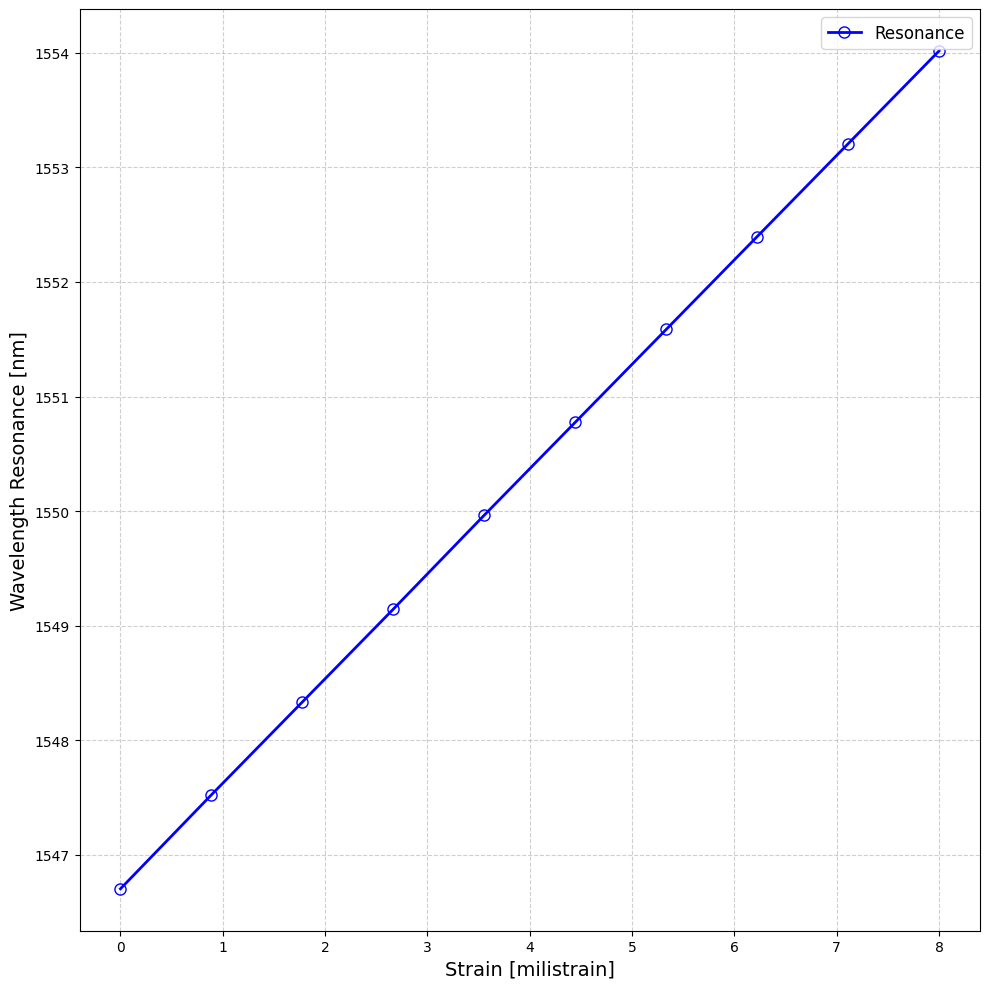

In [49]:
plt.figure(figsize=(10, 10))

plt.plot(
    S*1e3,
    frequencia_onde_ocorre_maxima_transmissao_strain,
    '-o',
    color='blue',
    markerfacecolor='none',  # bola vazada
    markersize=8,
    linewidth=2,
    label="Resonance"
)

plt.xlabel("Strain [milistrain]", fontsize=14)
plt.ylabel("Wavelength Resonance [nm]", fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.getcwd() + fr"\RESULTADOS\ressonancia_vs_strain.png", dpi=300, bbox_inches="tight")

plt.show()


## S parameter Export - Strain 

In [50]:
S11 = np.zeros((len(wvg), 2*len(S)))
S21 = np.zeros((len(wvg), 2*len(S)))

for i in range(0,len(S),1):
    S11[:,2*i] = S11_modulo[i]
    S11[:,2*i+1] = S11_fase[i]

    S21[:,2*i] = S21_modulo[i]
    S21[:,2*i+1] = S21_fase[i]


In [51]:
filepath = r"C:\Users\gson5\Downloads\Photonics-API-lumapi\SILICON BRAGG\BRAGG STRAIN"
tamanho = len(os.listdir(filepath))

for i in range(tamanho):
    os.remove(fr"C:\Users\gson5\Downloads\Photonics-API-lumapi\SILICON BRAGG\BRAGG STRAIN\bragg_strain_{i+1}.dat")

In [52]:

# Parâmetros
c = 3e8
coln = 3
TM = np.transpose(S)
numMode = 1  # 1 modo
numPort = 2  # 2 portas
modeLabel = ["TE"]  # lista com rótulos de modos

for i in range(len(S)):
    filename = os.getcwd() + fr"\BRAGG STRAIN\bragg_strain_{i+1}.dat"
    with open(filename, "w") as f:
        for kk in range(numMode):
            for mm in range(numPort):  # porta de saída
                for nn in range(numPort):  # porta de entrada
                            mystr = (
                                f"(\"port {mm+1}\",\"{modeLabel[kk]}\",{kk+1},"
                                f"\"port {nn+1}\",1,\"modulation\")\n"
                                f"(1,{1})\n"
                            )
                            f.write(mystr)

                            f.write(f"{S[i]:.5f}" + "\n")

                            f.write(f"({len(wvg)},{coln})\n")

                            # Seleciona o conjunto de dados correto
                            if mm == 0 and nn == 0 and kk == 0:  # S11
                                mymtrx = np.column_stack((c / wvg, S11[:,2*i:2*i+2]))
                            elif mm == 1 and nn == 0 and kk == 0:  # S21
                                mymtrx = np.column_stack((c / wvg, S21[:,2*i:2*i+2]))
                            else:
                                mymtrx = np.column_stack((c / wvg, S11[:,2*i:2*i+2]))

                            # Escreve os dados numéricos
                            np.savetxt(f, mymtrx, fmt="%.6e", delimiter="\t")


## Interconnect

In [57]:
interacoes = 1
defasagem = 5.21
qtd_laser = 2

if (interacoes>1):
    defasagem = np.linspace(1,(x_max_S2-x_max_S1), interacoes) 

print(defasagem)

5.21


## Strain variation

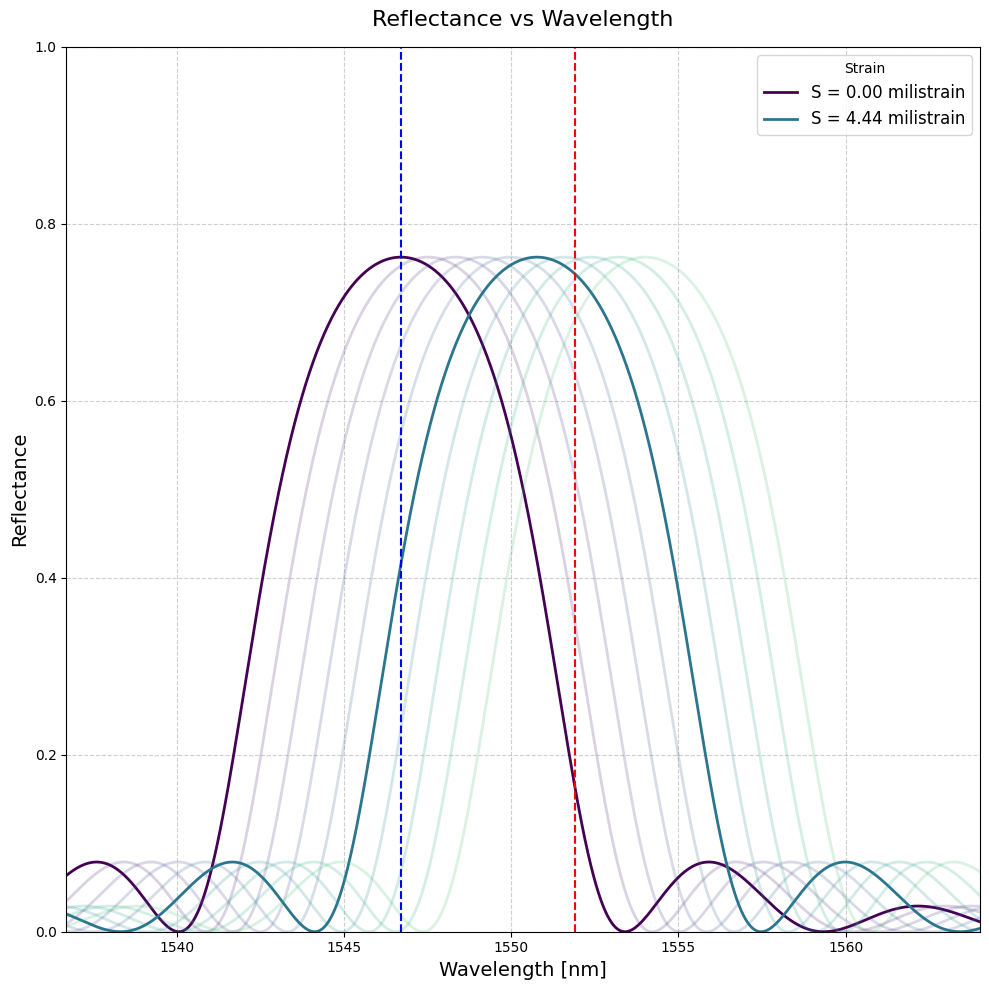

In [59]:

cmap = plt.cm.viridis(np.linspace(0, 0.7, len(S)))

plt.figure(figsize=(10, 10))

for i in range(len(S)):
    if (i%5 == 0):
        plt.plot(
            wvg * 1e9,
            Reflectance[i],
            markerfacecolor='none',  # bola vazada
            markersize=6,
            linewidth=2,
            color=cmap[i],
            label = f"S = {S[i]*1e3:.2f} milistrain"
        )
    else:
        plt.plot(
            wvg * 1e9,
            Reflectance[i],
            markerfacecolor='none',  # bola vazada
            markersize=6,
            alpha = 0.2,
            color= cmap[i],
            linewidth=2,
        )

plt.axvline(x=x_max_S1, color ="blue", linestyle ='--')

if (interacoes >1):
    for j in range(interacoes):
        x_max_S2=frequencia_onde_ocorre_maxima_transmissao_strain[0] + defasagem[j]
        if(j%4 == 0):
            plt.axvline(x=x_max_S2, color ="red",alpha=1, linestyle ='--')
        else:
            plt.axvline(x=x_max_S2, color ="red",alpha=0.2, linestyle ='--')
else:
    plt.axvline(x=x_max_S1+defasagem, color ="red", linestyle ='--')

    if(qtd_laser == 3):
        plt.axvline(x=x_max_S1+2*defasagem, color ="green", linestyle ='--')

plt.xlim(x_max_S1 - 10, x_max_S2 + 10)
plt.ylim(0, 1)

plt.xlabel("Wavelength [nm]", fontsize=14)
plt.ylabel("Reflectance", fontsize=14)
plt.title("Reflectance vs Wavelength", fontsize=16, pad=15)

plt.legend(title="Strain", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig(os.getcwd() + fr"\RESULTADOS\Reflectance_vs_wavelength_strain_com_comprimentos_dos_lasers.png", dpi=300, bbox_inches="tight")

plt.show()



In [60]:
pmS1 = np.zeros([len(S),interacoes])
pmS2 = np.zeros([len(S),interacoes])
pmS3 = np.zeros([len(S),interacoes])
pmS4 = np.zeros([len(S),interacoes])
inter = lumapi.INTERCONNECT()

for j in range(interacoes):
    for i in range(len(S)):
        if(interacoes>1):
            P1,P2 = utils.funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_max_S1*1e-9,defasagem[j]*1e-9,os.getcwd() +fr"\BRAGG STRAIN\bragg_strain_{i+1}.dat")
        else:
            P1,P2 = utils.funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_max_S1*1e-9,defasagem*1e-9,os.getcwd() +fr"\BRAGG STRAIN\bragg_strain_{i+1}.dat")
            
            if(qtd_laser == 3):
                P3,P4 = utils.funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_max_S1*1e-9+defasagem*1e-9,defasagem*1e-9,os.getcwd() +fr"\BRAGG STRAIN\bragg_strain_{i+1}.dat")
                pmS3[i,j] = P3
                pmS4[i,j] = P4
        pmS1[i,j] = P1
        pmS2[i,j] = P2


C:\Users\gson5\AppData\Local\Temp\ipykernel_25144\1476883708.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(


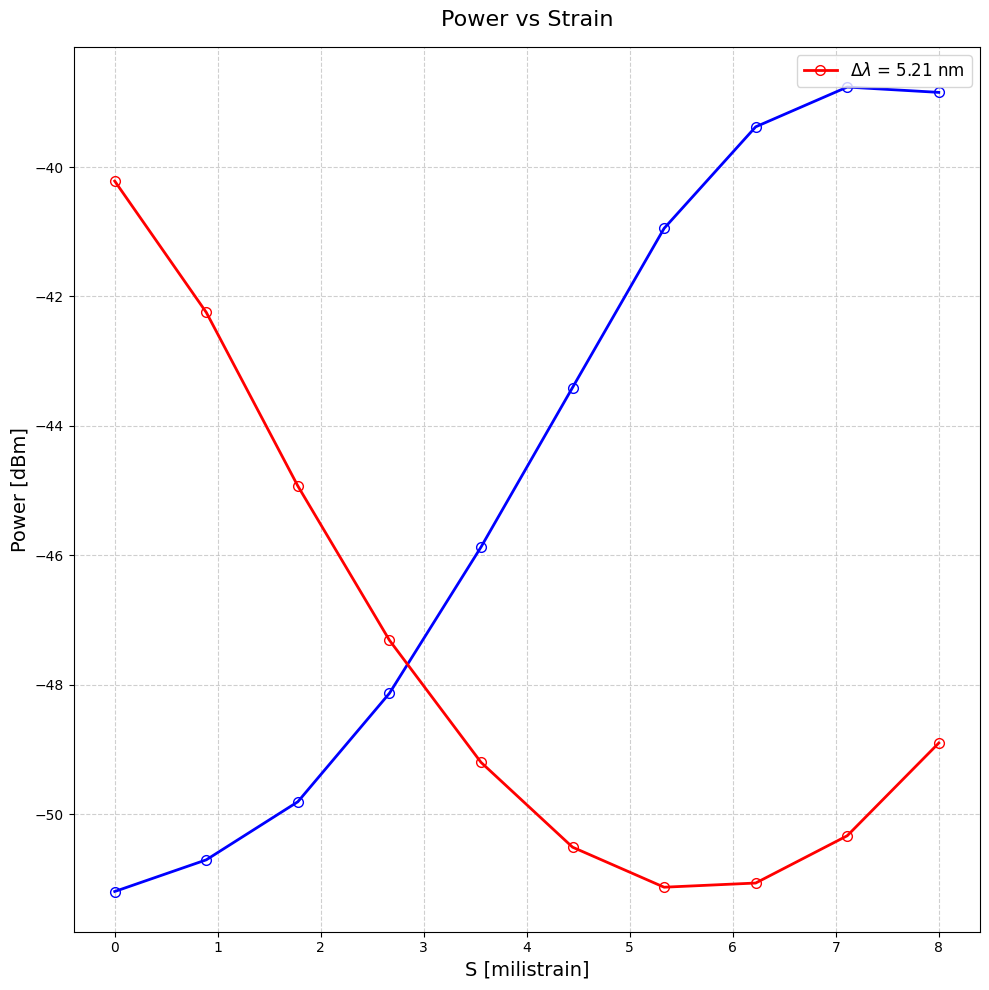

In [61]:
if interacoes == 1:
    plt.figure(figsize=(10, 10))

    for j in range(interacoes):
        plt.plot(
            S*1e3, pmS1[:,j],
            '-o',
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            linestyle = "-",
            color = "blue"
        )

        plt.plot(
            S*1e3, pmS2[:,j],
            '-o',
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            color = "red",
            label=fr"$\Delta \lambda$ = {defasagem:.2f} nm"
        )
        if(qtd_laser == 3):
            plt.plot(
                S*1e3, pmS3[:,j],
                '-o',
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                linestyle = "--",
                color = "red"
            )

            plt.plot(
                S*1e3, pmS4[:,j],
                '-o',
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                color = "green",
                label=fr"$\Delta \lambda$ = {2*defasagem:.2f} nm"
            )


    plt.xlabel("S [milistrain]", fontsize=14)
    plt.ylabel("Power [dBm]", fontsize=14)
    plt.title("Power vs Strain", fontsize=16, pad=15)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\potencia_vs_strain.png", dpi=300, bbox_inches="tight")

    plt.show()


<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:83: SyntaxWarning: invalid escape sequence '\D'
<>:93: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:46: SyntaxWarning: invalid escape sequence '\D'
<>:83: SyntaxWarning: invalid escape sequence '\D'
<>:93: SyntaxWarning: invalid escape sequence '\D'
C:\Users\gson5\AppData\Local\Temp\ipykernel_25144\1618335585.py:16: SyntaxWarning: invalid escape sequence '\D'
  label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
C:\Users\gson5\AppData\Local\Temp\ipykernel_25144\1618335585.py:26: SyntaxWarning: invalid escape sequence '\D'
  label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
C:\Users\gson5\AppData\Local\Temp\ipykernel_25144\161833

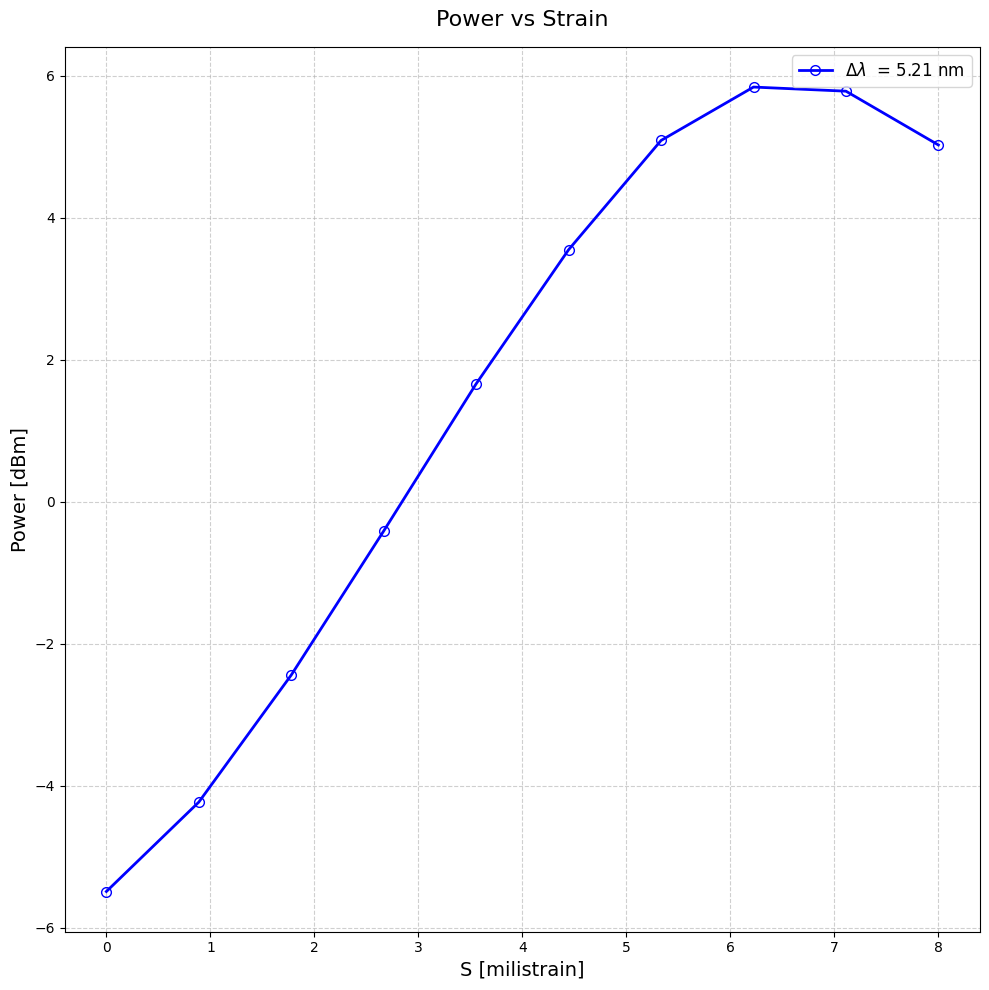

In [64]:
indice_do_vetor_ate_onde_a_razao_eh_linear = 7

if (interacoes>1):
    plt.figure(figsize=(10, 10))

    for j in range(interacoes):
        
        if j==0:
            plt.plot(
                S*1e3, (np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2,
                '-o',
                color="black",
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
            )
        elif j==7:
            plt.plot(
                S*1e3,(np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2,
                '-o',
                color="red",
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
            )
        elif j==13:
            plt.plot(
                S*1e3, (np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2,
                '-o',
                color="blue",
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
            )
        elif j==29:
            plt.plot(
                S*1e3, (np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2,
                '-o',
                color="green",
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                label = f"$\Delta \lambda$ = {defasagem[j]:.2f} nm"
            )
        else:
            plt.plot(
                S*1e3, (np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2,
                '-',
                color='red',
                markerfacecolor='none',
                markersize=7,
                linewidth=2,
                alpha = 0.2
            )
        
    plt.axvline(x=S[indice_do_vetor_ate_onde_a_razao_eh_linear]*1e3, linestyle="--",
                 label =f"S = {S[indice_do_vetor_ate_onde_a_razao_eh_linear]*1e3:.2f} milistrain")
    plt.xlabel("Strain [milistrain]", fontsize=14)
    plt.ylabel("P1/P2", fontsize=14)
    plt.title("P1/P2 vs Strain", fontsize=16, pad=15)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\razao_potencia_vs_strain.png", dpi=300, bbox_inches="tight")

    plt.show()
else:
    plt.figure(figsize=(10, 10))

    # Linha 1 com bolas vazadas
    plt.plot(
        S*1e3, (np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2,
        '-o',
        color='blue',
        markerfacecolor='none',
        markersize=7,
        linewidth=2,
        label=f"$\Delta \lambda$  = {defasagem:.2f} nm"
    )
    if(qtd_laser==3):
        plt.plot(
            S*1e3, pmS4[:,0]/pmS3[:,0],
            '-o',
            color='red',
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            label=f"$\Delta \lambda$ = {2*defasagem:.2f} nm"
        )
    # Labels e título
    plt.xlabel("S [milistrain]", fontsize=14)
    plt.ylabel("Power [dBm]", fontsize=14)
    plt.title("Power vs Strain", fontsize=16, pad=15)

    # Estética
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Salvar em alta resolução
    plt.savefig("potencia_vs_strain.png", dpi=300, bbox_inches="tight")

    plt.show()


In [65]:
indice_do_grafico = 0


razao=(np.array(pmS1[:,indice_do_grafico])-np.array(pmS2[:,indice_do_grafico]))/2
razao_ajustada = razao[0:indice_do_vetor_ate_onde_a_razao_eh_linear]
S_ajustado = S[0:indice_do_vetor_ate_onde_a_razao_eh_linear]

a, b = np.polyfit(S_ajustado*1e-3, razao_ajustada, 1)
y_fit = a*S_ajustado*1e-3 + b

sensibilidade = (razao[indice_do_vetor_ate_onde_a_razao_eh_linear-3]-razao[0])/((S[indice_do_vetor_ate_onde_a_razao_eh_linear-3]-S[0]))
sensibilidade_fit = (y_fit[indice_do_vetor_ate_onde_a_razao_eh_linear-1]-y_fit[0])/((S_ajustado[indice_do_vetor_ate_onde_a_razao_eh_linear-1]-S_ajustado[0]))
erro_percentual = np.abs((razao_ajustada - y_fit) / razao_ajustada) * 100
erro_medio = np.mean(erro_percentual)
desvio_padrao_do_erro_percentual = np.std(erro_percentual)

print(sensibilidade, "por milistrain")
print(sensibilidade_fit, "por milistrain")
print(f"Erro percentual medio= {erro_medio:.3f} %")
print("Desvio padrao do erro percentual =", desvio_padrao_do_erro_percentual)


2010.599837964645 por milistrain
2064.4101695999398 por milistrain
Erro percentual medio= 8.721 %
Desvio padrao do erro percentual = 5.805359099374038


<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
C:\Users\gson5\AppData\Local\Temp\ipykernel_25144\1356539665.py:14: SyntaxWarning: invalid escape sequence '\D'
  label = f"$\Delta \lambda$ = {defasagem[j] if (interacoes>1) else defasagem:.2f} nm"
C:\Users\gson5\AppData\Local\Temp\ipykernel_25144\1356539665.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

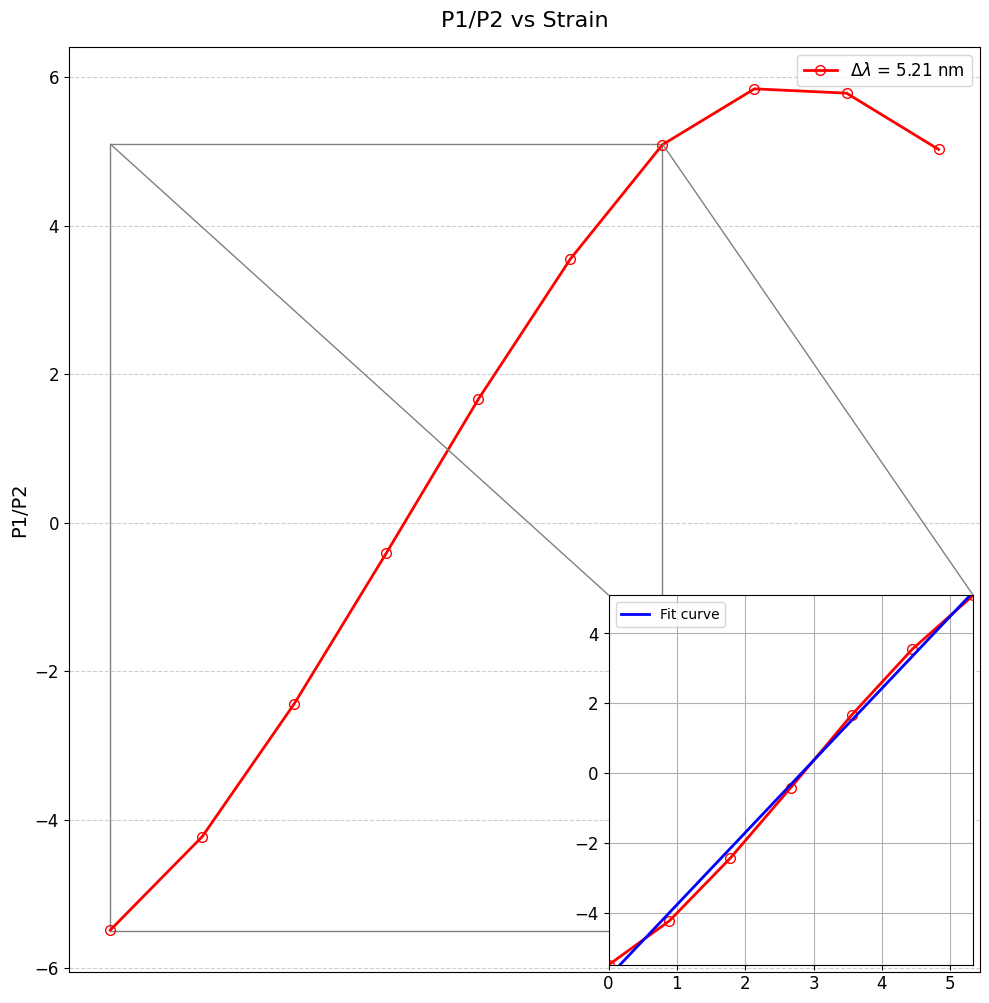

In [66]:
plt.figure(figsize=(10, 10))

fig, ax = plt.subplots(figsize=(10, 10))

for j in range(interacoes):
    if j==indice_do_grafico:
        ax.plot(
            S*1e3, (np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2,
            '-o',
            color="red",
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            label = f"$\Delta \lambda$ = {defasagem[j] if (interacoes>1) else defasagem:.2f} nm"
        )
    else:
        ax.plot(
            S*1e3, (np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2,
            '-',
            color='red',
            markerfacecolor='none',
            markersize=7,
            linewidth=2,
            alpha = 0.2
        )
ax.set_xlabel("Strain [milistrain]", fontsize=14)
ax.set_ylabel("P1/P2", fontsize=14)
ax.set_title("P1/P2 vs Strain", fontsize=16, pad=15)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.set_visible(False)  # remove o eixo x e os ticks
ax.tick_params(axis='both', which='major', labelsize=12)  # muda tamanho dos números do eixo x e y

# Criando o inset (zoom)
axins = inset_axes(ax, width="40%", height="40%", loc='lower right')

for j in range(interacoes):
    y = (np.array(pmS1[:,j])-np.array(pmS2[:,j]))/2
    if j == indice_do_grafico:
        axins.plot(
            S*1e3, y,
            '-o',
            color="red",
            markerfacecolor='none',
            markersize=7,
            linewidth=2
        )
    else:
        axins.plot(
            S*1e3, y,
            '-',
            color='red',
            alpha=0.2,
            linewidth=2
        )

axins.plot(
            S_ajustado*1e3, y_fit,
            '-',
            color='blue',
            alpha=1,
            linewidth=2,
            label = "Fit curve"
        )

# Limites do zoom — ajuste conforme região que deseja destacar
x1, x2 = S[0]*1e3, S[indice_do_vetor_ate_onde_a_razao_eh_linear-1]*1e3  # exemplo de limites no eixo x
y1, y2 = min(razao_ajustada)-0.01, max(razao_ajustada)+0.01  # exemplo de limites no eixo y
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.legend()
axins.grid()

# Linha que conecta inset ao gráfico principal
mark_inset(ax, axins, loc1=(1), loc2=2, fc="none", ec="0.5")
axins.tick_params(axis='both', which='major', labelsize=12)  # muda tamanho dos números do eixo x e y

plt.tight_layout()
plt.savefig(os.getcwd() + fr"\RESULTADOS\razao_potencia_e_fit_vs_strain.png", dpi=300, bbox_inches="tight")
plt.show()


## Temperature variation

In [ ]:
if(len(Temperatura)>0):
    plt.figure(figsize=(10, 10))

    for i in range(len(Temperatura)):
        plt.plot(
            wvg * 1e9,
            Transmissao_T[i],
            label=f"{Temperatura[i] - 273:.1f} °C",
            linewidth=2
        )

    x_max1, _ = utils.achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
        Transmissao_T[0], wvg*1e9, 1500, 1600
    )
    x_max2, _ = utils.achar_x_e_y_maximo_em_um_intervalo_quando_tiver_varios_picos(
        Transmissao_T[-1], wvg*1e9, 1500, 1600
    )

    plt.axvline(x=x_max1, color ="blue", linestyle ='--')
    plt.axvline(x=x_max2, color ="red", linestyle ='--')

    plt.xlim(x_max1 - 10, x_max2 + 10)

    plt.xlabel("Wavelength [nm]", fontsize=14)
    plt.ylabel("Reflectance", fontsize=14)
    plt.title("Reflectance vs Wavelength", fontsize=16, pad=15)

    plt.legend(title="Temperatura", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\reflectance_vs_wavelength_temperatura_com_comprimento_dos_lasers", dpi=300, bbox_inches="tight")

    plt.show()

In [ ]:
if(len(Temperatura)>0):
    pmT1 = []
    pmT2 = []

    for i in range(len(Temperatura)):
        P1,P2 = utils.funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser(inter,x_max1*1e-9,(x_max2-x_max1)*1e-9,os.getcwd() +fr"\BRAGG TEMPERATURE\bragg_temperature_{i+1}.dat")
        pmT1.append(inter.getresult("PM1","total power"))
        pmT2.append(inter.getresult("PM2","total power"))

In [ ]:
if(len(Temperatura)>0):
    plt.figure(figsize=(10, 10))

    plt.plot(
        Temperatura - 273, pmT1,
        '-o',
        color='blue',
        markerfacecolor='none',
        markersize=7,
        linewidth=2,
        label=fr"Operando em $\lambda$ = {x_max1:.2f} nm"
    )

    plt.plot(
        Temperatura - 273, pmT2,
        '-o',
        color='red',
        markerfacecolor='none',
        markersize=7,
        linewidth=2,
        label=fr"Operando em $\lambda$ = {x_max2:.2f} nm"
    )

    plt.xlabel("T [°C]", fontsize=14)
    plt.ylabel("Power [dBm]", fontsize=14)
    plt.title("Power vs Temperature", fontsize=16, pad=15)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\potencia_vs_temperatura.png", dpi=300, bbox_inches="tight")

    plt.show()


In [ ]:
if(len(Temperatura)>0):
    plt.figure(figsize=(10, 10))

    plt.plot(
        Temperatura - 273, np.array(pmT2)/np.array(pmT1),
        '-o',
        color='blue',
        markerfacecolor='none',
        markersize=7,
        linewidth=2,
    )

    plt.xlabel("T [°C]", fontsize=14)
    plt.ylabel("P1/P2", fontsize=14)
    plt.title("P1/P2 vs Temperature", fontsize=16, pad=15)

    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    plt.savefig(os.getcwd() + fr"\RESULTADOS\razao_potencia_vs_temperatura.png", dpi=300, bbox_inches="tight")

    plt.show()
